# Analysis Development
 - Given the user has access to Spotify, this script will return a simple plot of their liked songs grouped by day and number of songs liked per day
 - Additional updated research will be appended in here

##### Import the modules

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import spotipy
from spotipy import SpotifyOAuth

##### Client ID and Secret are passed from an external source

In [27]:
import settings

In [28]:
# Client ID and Client Secret is called and used
spotify_client_id = settings.SPOTIFY_CLIENT_ID
spotify_client_secret = settings.SPOTIFY_CLIENT_SECRET
spotify_redirect_uri = "http://localhost:5000/callback"

##### With the application setup, we just need to call in the authenticator and method itself
 - This will vary based on the type of access. For me, it is suitable.

In [29]:
# provide scope of access for Python which requests access from the current user
scope =  'user-library-read user-top-read user-read-private playlist-read-private playlist-read-collaborative playlist-modify-public playlist-modify-private'

# authentication manager ensures secured point of access from spotify to python to client (me)
auth_manager = SpotifyOAuth(
                            scope = scope, 
                            client_id = spotify_client_id,
                            client_secret = spotify_client_secret,
                            redirect_uri = spotify_redirect_uri
                            )

# initial call of spotify using authentication manager
sp = spotipy.Spotify(auth_manager = auth_manager)

##### Test connection (expectancy of a dict response with personal info)

In [30]:
sp.current_user()

{'display_name': '121631289',
 'external_urls': {'spotify': 'https://open.spotify.com/user/121631289'},
 'href': 'https://api.spotify.com/v1/users/121631289',
 'id': '121631289',
 'images': [{'url': 'https://i.scdn.co/image/ab67757000003b82d01c89064802f0d7d779da0f',
   'height': 64,
   'width': 64},
  {'url': 'https://i.scdn.co/image/ab6775700000ee85d01c89064802f0d7d779da0f',
   'height': 300,
   'width': 300}],
 'type': 'user',
 'uri': 'spotify:user:121631289',
 'followers': {'href': None, 'total': 13},
 'country': 'US',
 'product': 'premium',
 'explicit_content': {'filter_enabled': False, 'filter_locked': False},
 'email': 'nsung214@gmail.com'}

##### Users Top Tracks

In [31]:
sp.current_user_top_tracks()

{'items': [{'album': {'album_type': 'SINGLE',
    'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4iMO20EPodreIaEl8qW66y'},
      'href': 'https://api.spotify.com/v1/artists/4iMO20EPodreIaEl8qW66y',
      'id': '4iMO20EPodreIaEl8qW66y',
      'name': 'Still Woozy',
      'type': 'artist',
      'uri': 'spotify:artist:4iMO20EPodreIaEl8qW66y'}],
    'available_markets': ['AR',
     'AU',
     'AT',
     'BE',
     'BO',
     'BR',
     'BG',
     'CA',
     'CL',
     'CO',
     'CR',
     'CY',
     'CZ',
     'DK',
     'DO',
     'DE',
     'EC',
     'EE',
     'SV',
     'FI',
     'FR',
     'GR',
     'GT',
     'HN',
     'HK',
     'HU',
     'IS',
     'IE',
     'IT',
     'LV',
     'LT',
     'LU',
     'MY',
     'MT',
     'MX',
     'NL',
     'NZ',
     'NI',
     'NO',
     'PA',
     'PY',
     'PE',
     'PH',
     'PL',
     'PT',
     'SG',
     'SK',
     'ES',
     'SE',
     'CH',
     'TW',
     'TR',
     'UY',
     'US',
     'GB',
 

##### While loop to collect all songs in my liked

In [32]:
liked_songs = []
offset = 0
users_liked = sp.current_user_saved_tracks(limit = 50)

while users_liked["next"] != None:
    liked_songs.extend(users_liked["items"])
    offset+=50
    users_liked = sp.current_user_saved_tracks(offset=offset,limit = 50)

liked_songs.extend(users_liked["items"])

##### Observed collection of my liked songs 

In [33]:
len(liked_songs)

1796

In [34]:
df = pd.DataFrame(list(map(lambda x: x["track"],liked_songs)))

In [35]:
df2 = pd.DataFrame(liked_songs)

In [36]:
df["added_at"] = pd.to_datetime(df2["added_at"]).dt.strftime('%Y-%m-%dT%H:%M:%SZ')


In [37]:
# df["release_date"] = df["album"].apply(lambda x: x["release_date"])
df["release_date"] = pd.to_datetime(df["album"].apply(lambda x: x["release_date"]), format='ISO8601').dt.strftime('%Y-%m-%d')

In [39]:
from datetime import datetime, timezone
df["added_at"] = pd.to_datetime(df["added_at"], format= 'ISO8601')
df["release_date"] = pd.to_datetime(df["release_date"], format= 'ISO8601')

In [42]:
df["added_at"] = pd.to_datetime(df["added_at"].dt.strftime('%Y-%m-%d'))

In [49]:
df["date_difference"] = (df["added_at"]-df["release_date"]).dt.days

In [61]:
# df["added_at"].dt.day
# df["added_at"].dt.month
# df["added_at"].dt.year

# df2 = df["added_at"].dt.month
date_grouped = df.groupby("added_at").count()

In [90]:
daily_songs_liked = date_grouped['id'].reset_index()
daily_songs_liked['month'] = daily_songs_liked['added_at'].dt.month
daily_songs_liked['year'] = daily_songs_liked['added_at'].dt.year
monthly_songs_liked = daily_songs_liked.groupby(["year", "month"]).agg({'id':np.sum}).reset_index()

C:\Users\nsung\AppData\Local\Temp\ipykernel_11564\2890141356.py:4: FutureWarning: The provided callable <function sum at 0x000001C0A52514E0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  monthly_songs_liked = daily_songs_liked.groupby(["year", "month"]).agg({'id':np.sum}).reset_index()


Text(0.5, 1.0, 'My Liked Songs from Spotify')

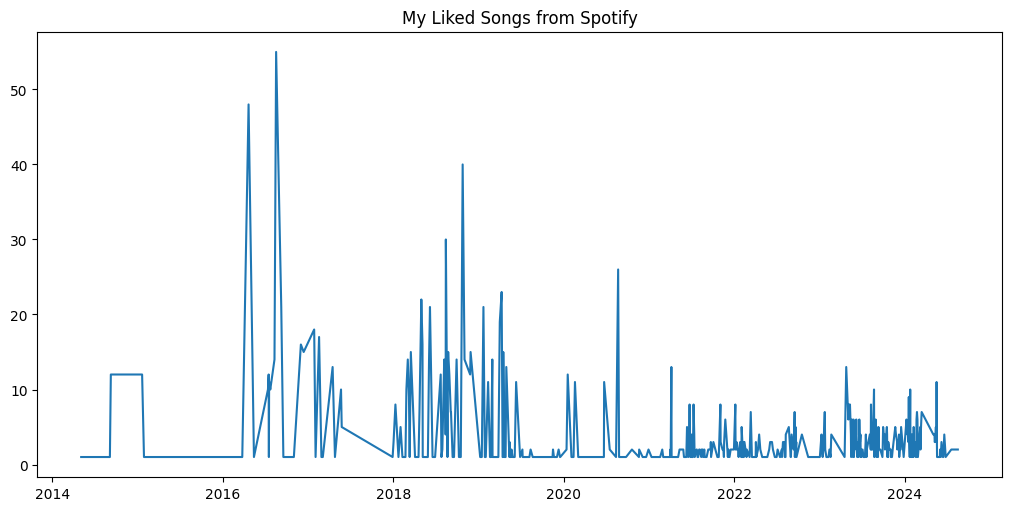

In [80]:
# date_grouped["id"]
fig, ax = plt.subplots(figsize=(10,5), layout = 'constrained')
ax.plot('added_at', 'id', data = date_grouped['id'].reset_index())
ax.set_title("My Liked Songs from Spotify")

AttributeError: 'list' object has no attribute 'ndim'

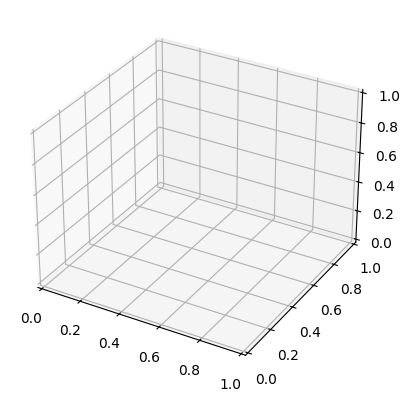

In [95]:
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
x,y,z = monthly_songs_liked['year'], monthly_songs_liked['month'], monthly_songs_liked['id']

ax.plot_wireframe(x,z,[x,y, rstride=10, cstride=10)